In [2]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from imm import *
from simple_kalman import *
from bayes import *
from particle import *

2024-09-17 18:40:33.995484: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-17 18:40:35.140573: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Load dataset

In [3]:
synthetic_dataset =  "/home/annalena/PedestrianTrajectoryPrediction/datasets/test_dataset_synth"
jrdb_original = "/home/annalena/PedestrianTrajectoryPrediction/datasets/test_dataset_orig"
jrdb_odometry_processed = "/home/annalena/PedestrianTrajectoryPrediction/datasets/test_dataset_odom"
eth_augmented = "/home/annalena/PedestrianTrajectoryPrediction/datasets/test_dataset_eth_aug"
crowdbot_odom = "/home/annalena/PedestrianTrajectoryPrediction/datasets/crowdbot_test_data"
crowdbot_orig = "/home/annalena/PedestrianTrajectoryPrediction/datasets/crowdbot_test"

test_dataset =  tf.data.Dataset.load(synthetic_dataset)
test_dataset = tf.data.Dataset.unbatch(test_dataset)
test_dataset = test_dataset.batch(1000)

test_dataset2 =  tf.data.Dataset.load(crowdbot_odom)
test_dataset2 = tf.data.Dataset.unbatch(test_dataset2)
test_dataset2 = test_dataset2.batch(1000)

2024-09-17 18:40:56.850877: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-09-17 18:40:57.012881: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-09-17 18:40:57.013398: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-09-17 18:40:57.016157: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-09-17 18:40:57.016609: I tensorflow/compile

In [4]:
%matplotlib inline

In [5]:
def get_traj_crowdbot(trajectory1, trajectory2):
    return tf.gather(trajectory1, [0,2], axis=2)

def get_traj(trajectory1, trajectory2):
    return tf.gather(trajectory1, [0,1], axis=2)

def z_score_normalization(trajectory):
    # Calculate mean and standard deviation along the timestep axis (axis=0)
    mean = tf.reduce_mean(trajectory, axis=0)
    std = tf.math.reduce_std(trajectory, axis=0)
    
    # Apply Z-score normalization: (x - mean) / std
    normalized_trajectory = (trajectory - mean) / std
    return normalized_trajectory

# Apply the Z-score normalization to each trajectory in the dataset
test_dataset = test_dataset.map(get_traj)
#test_dataset = test_dataset.map(z_score_normalization)

# Load model and predict

In [6]:
%matplotlib inline

In [7]:
model1 = Kalman_CV(pos_dim=2)
model2 = IMM_CVCT_2D(pos_dim=2)
model3 = ParticleFilter()

In [8]:
model1.params = {'P': 1.0, 'dt': 1, 'q': 0.1, 'r': 1} 
model2.params = {'P': 1.0, 'dt': 1, 'omega_variance': 0.1, 'q': 1.0, 'r': 1.0,
                 'M': [[0.70, 0.1, 0.1, 0.1],  # High likelihood of staying in CV
                        [0.1, 0.7, 0.1, 0.1],
                        [0.1, 0.1, 0.7, 0.1],
                        [0.1, 0.1, 0.1, 0.7]], } 
model3.params = {'dt': 1, 'measurement_noise': 0.01, 'num_particles': 5000, 'process_noise_cv': 0.01}

In [9]:
import time
for batch_x1 in test_dataset.take(1):
    start_time = time.time()
    predictions1 = model1.predict(batch_x1)
    end_time = time.time()
    print(f"Execution Time: {end_time - start_time} seconds")
    start_time = time.time()
    predictions2 = model2.predict(batch_x1)
    end_time = time.time()
    print(f"Execution Time: {end_time - start_time} seconds")
    start_time = time.time()
    predictions3 = model3.predict(batch_x1)
    end_time = time.time()
    print(f"Execution Time: {end_time - start_time} seconds")

[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:1: Invalid control characters encountered in text.
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:3: Expected identifier, got: 783722239982921390


Execution Time: 5.645761966705322 seconds
Execution Time: 14.874439716339111 seconds
Execution Time: 20.06653594970703 seconds


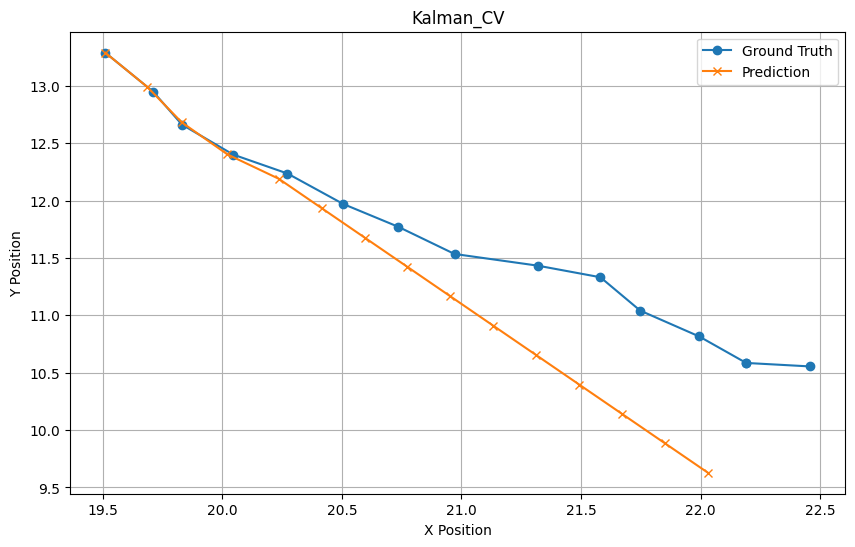

In [10]:
idx = 36
model1.plot_predictions(batch_x1[idx:], predictions1[idx:], sample_index=0)

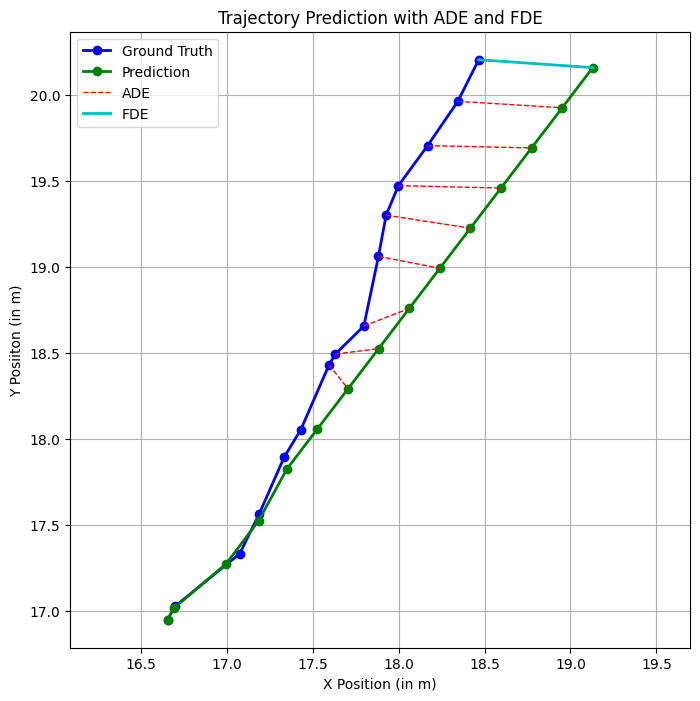

In [20]:
def euclidean_distance(p1, p2):
    return np.linalg.norm(np.array(p1) - np.array(p2))
plt.figure(figsize=(8, 8))

ground_truth= batch_x1[40][:15,:2]
prediction = predictions1[40][:15,:2]

plt.plot(ground_truth[:, 0], ground_truth[:, 1], 'bo-', label='Ground Truth', linewidth=2)
plt.plot(prediction[:, 0], prediction[:, 1], 'go-', label='Prediction', linewidth=2)

# Calculate and plot ADE (Average Displacement Error)
for i in range(6,15):
    plt.plot([ground_truth[i, 0], prediction[i, 0]], [ground_truth[i, 1], prediction[i, 1]], 
             'r--', label='ADE' if i == 7 else "", linewidth=1)

# Highlight FDE (Final Displacement Error) with a different color
plt.plot([ground_truth[-1, 0], prediction[-1, 0]], [ground_truth[-1, 1], prediction[-1, 1]], 
         'c-', label='FDE', linewidth=2)

# Plot configuration
plt.xlabel('X Position (in m)')
plt.ylabel('Y Posiiton (in m)')
plt.title('Trajectory Prediction with ADE and FDE')
plt.legend(loc='best')
plt.grid(True)
plt.axis('equal')

# Show plot
plt.show()

In [12]:
# load hst predicitions
with open('best_synth_pred.npy', 'rb') as f:
    hst_pred = np.load(f, allow_pickle=True)

In [21]:
# model multiple predicitions
def plot_predictions(ground_truth, predictions1, predictions2, predictions3, predictions4, sample_index, tmpT=5):
        gt_x = ground_truth[sample_index, :, 0]
        gt_y = ground_truth[sample_index, :, 1]
        pred_x1 = predictions1[sample_index, tmpT:, 0]
        pred_y1 = predictions1[sample_index, tmpT:, 1]
        pred_x2 = predictions2[sample_index, tmpT:, 0]
        pred_y2 = predictions2[sample_index, tmpT:, 1]
        pred_x3 = predictions3[sample_index, tmpT:, 0]
        pred_y3 = predictions3[sample_index, tmpT:, 1]
        pred_x4 = predictions4[sample_index, tmpT+1:, 0]
        pred_y4 = predictions4[sample_index, tmpT+1:, 1]

        plt.figure(figsize=(10, 6))
        plt.plot(gt_x[tmpT:], gt_y[tmpT:], 'x-', color='black', label='Ground Truth')
        plt.plot(gt_x[:tmpT], gt_y[:tmpT], 'o-', color='black')
        plt.plot(pred_x1, pred_y1,'rx-',  label='KF')
        plt.plot(pred_x2, pred_y2,'bx-', label='IMM')
        plt.plot(pred_x3, pred_y3,'gx-',  label='PF')
        plt.plot(pred_x4, pred_y4,'yx-',  label='HST')
        plt.xlabel('X Position (in m)')
        plt.ylabel('Y Position (in m)')
        plt.title("synthetic dataset")
        plt.legend()
        plt.grid(True)
        plt.show()


930


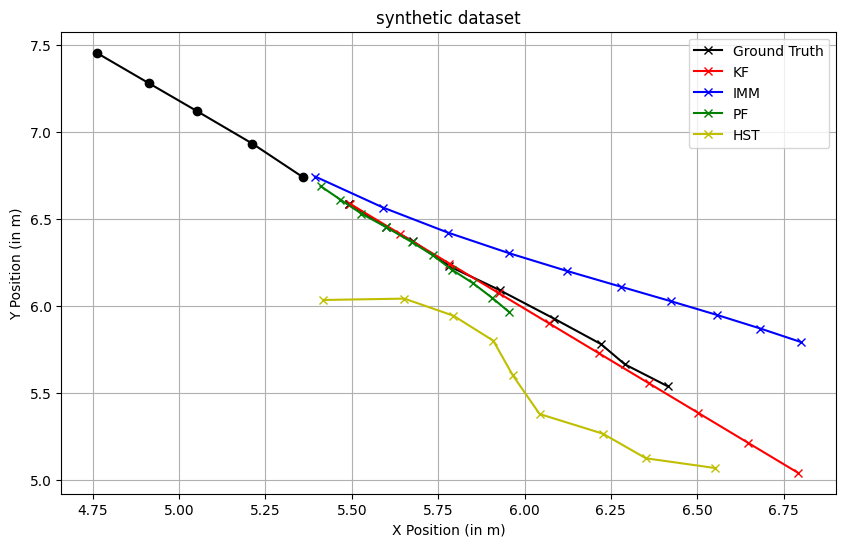

565


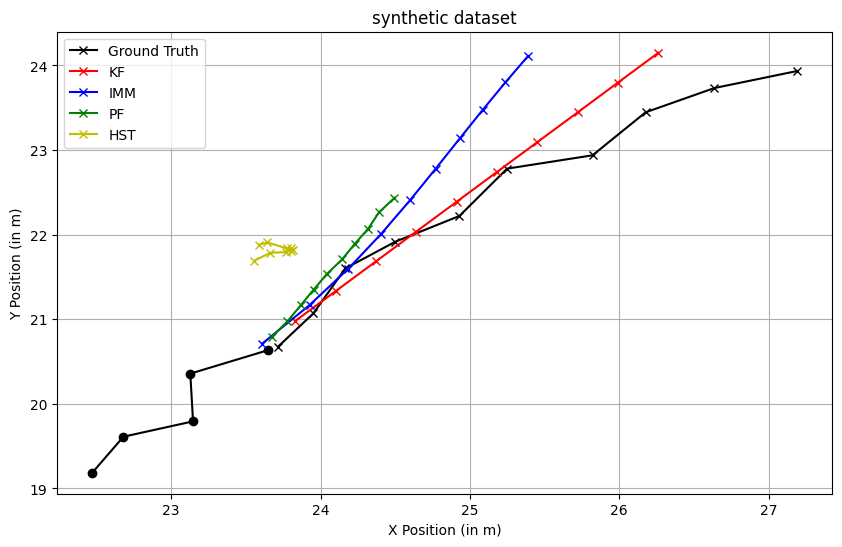

121


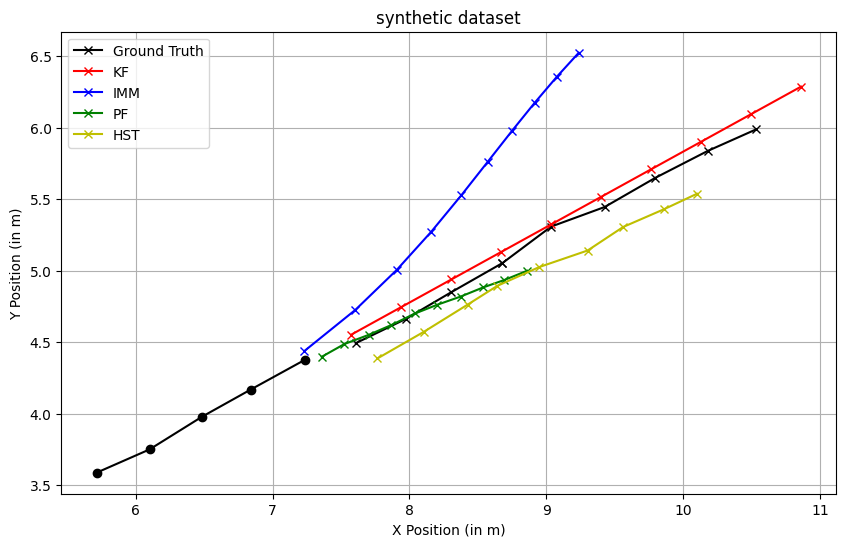

645


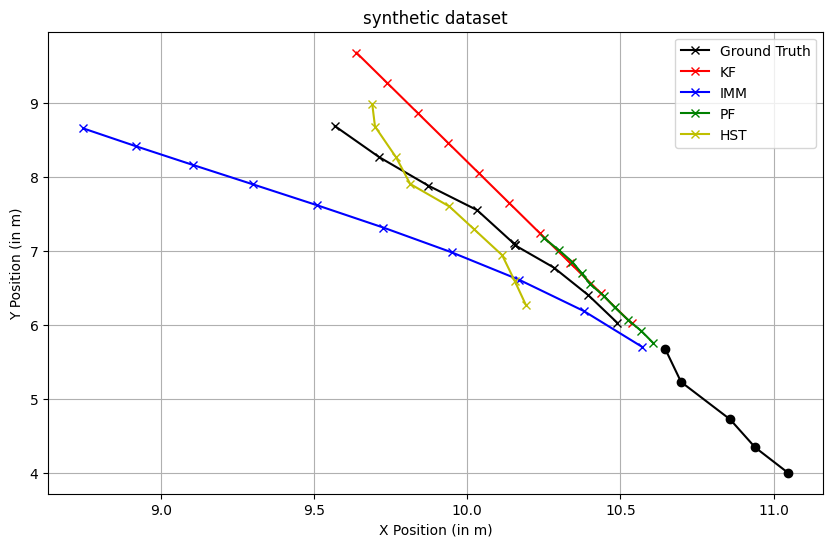

250


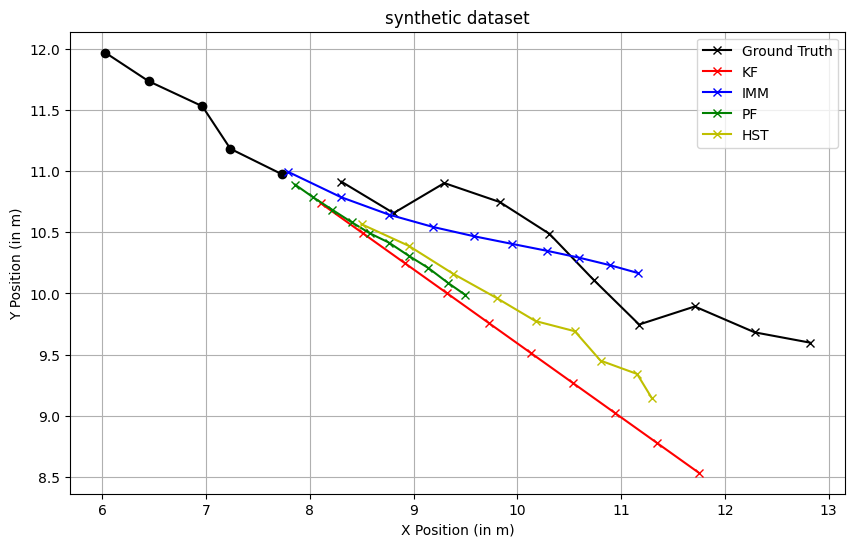

590


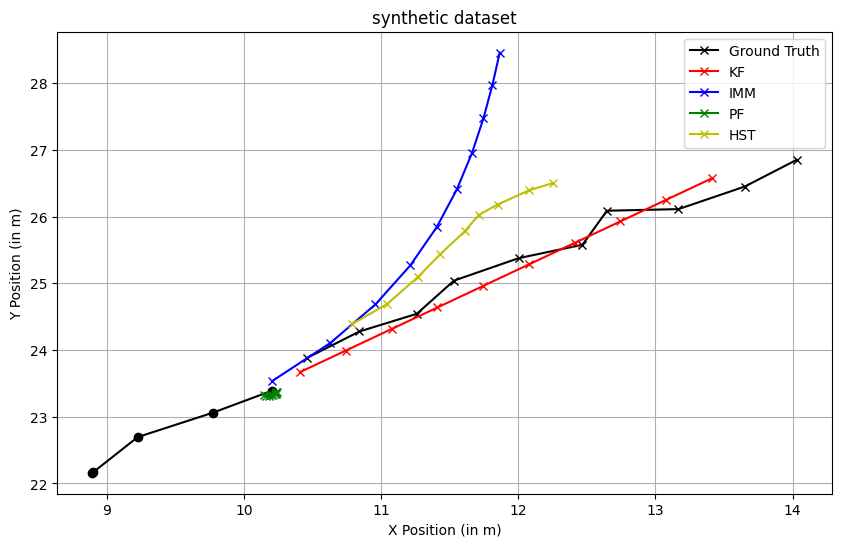

11


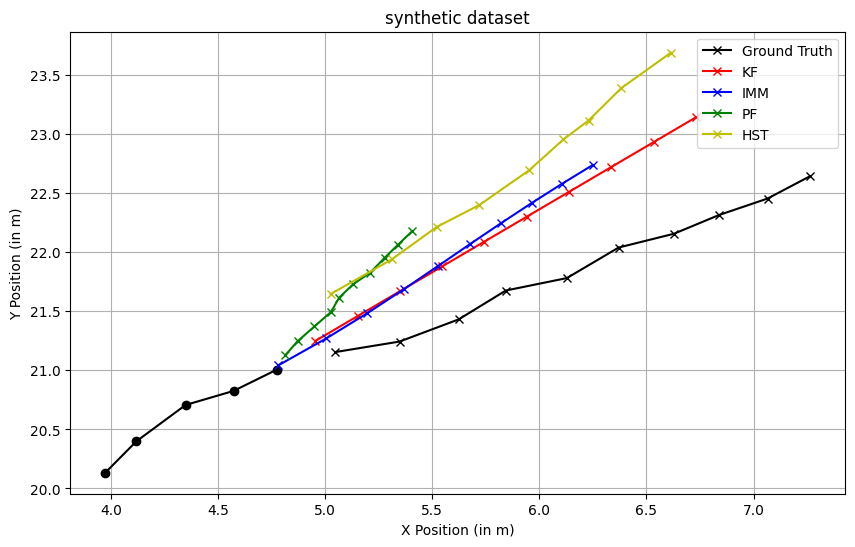

In [25]:
for idx in [930,565,121,645,250,590,11]:#[0,2, 3, 101, 103, 105, 200, 202]:
    print(idx)
    plot_predictions(batch_x1[idx:], predictions1[idx:], predictions2[idx:], predictions3[idx:], hst_pred[idx:], sample_index=0)

In [33]:
meanADE = model1.calculate_meanADE(batch_x1[:,6:,:2], predictions1[:,6:,:2], 2)
meanFDE = model1.calculate_meanFDE(batch_x1[:,6:,:2], predictions1[:,6:,:2])
print("KF")
print("mean ADE", meanADE)
print("mean FDE", meanFDE)
meanADE = model2.calculate_meanADE(batch_x1[:,6:,:2], predictions2[:,6:,:2], 2)
meanFDE = model2.calculate_meanFDE(batch_x1[:,6:,:2], predictions2[:,6:,:2])
print("IMM")
print("mean ADE", meanADE)
print("mean FDE", meanFDE)
meanADE = model3.calculate_meanADE(batch_x1[:,6:,:2], predictions3[:,6:,:2], 2)
meanFDE = model3.calculate_meanFDE(batch_x1[:,6:,:2], predictions3[:,6:,:2])
print("PF")
print("mean ADE", meanADE)
print("mean FDE", meanFDE)

KF
mean ADE 0.5237799473023877
mean FDE 0.8252294854800002
IMM
mean ADE 0.9324638545834903
mean FDE 1.5815403053844796
PF
mean ADE 1.224715684896221
mean FDE 1.9727012548165686


# Hyperparameter Optimization

In [42]:
model.hyperparameter_tuning(batch_x1[:,:,:2])

KeyboardInterrupt: 

In [31]:
hst_pred.shape

(1000, 15, 2)

In [32]:
meanADE = model1.calculate_meanADE(batch_x1[:,6:,:2], hst_pred[:,6:,:2], 2)
meanFDE = model1.calculate_meanFDE(batch_x1[:,6:,:2], hst_pred[:,6:,:2])
print("mean ADE", meanADE)
print("mean FDE", meanFDE)

mean ADE 0.5960011659456763
mean FDE 0.9193271937119616


In [17]:
from sklearn.model_selection import ParameterGrid

# Updated error calculation function to compare only positions
def calculate_meanADE(ground_truth, predictions, dim):
    predicted_positions = predictions[:, :, :dim]
    displacement_errors = np.linalg.norm(ground_truth - predicted_positions, axis=2)
    ADE = np.mean(np.mean(displacement_errors, axis=1))
    return ADE

# Define the parameter grid
param_grid = {
    'q': [0.1, 0.2, 0.5, 0.8, 1.0], 
     'r': [0.1, 0.2, 0.5, 0.8, 1.0], 
     'P':[0.1, 0.5, 1.0, 10.0], 
    'M': [[[0.9, 0.1],[0.1, 0.9]],
          [[0.8, 0.2],[0.2, 0.8]],
          [[0.6, 0.4],[0.4, 0.6]],
          [[0.5, 0.5],[0.5, 0.5]]
                         ], 
    'dt':  [0.1,0.4,0.9], 
    'omega_variance':[0.1, 0.2, 0.5, 0.8, 1.0]

}

# Generate combinations of parameters
grid = ParameterGrid(param_grid)

best_score = float('inf')
best_params = None

# Grid search loop
for params in grid:
    # Initialize the IMMParticleFilter with current parameters
    model = IMM_CVCT_2D(pos_dim=2)
    model.params['q'] = params['q']
    model.params['r'] = params['r']
    model.params['P'] = params['P']
    model.params['M'] = params['M']
    model.params['dt'] = params['dt']
    model.params['omega_variance'] = params['omega_variance']
    
    # Run the filter on your data and calculate the prediction error
    predictions = model.predict(ds_2d[1][:])
    
    # Calculate the error using the modified function
    error = calculate_meanADE(ds_2d[1][:], predictions, dim=2)

    # Update the best parameters if the current configuration yields a lower error
    if error < best_score:
        best_score = error
        best_params = params

# Print the best hyperparameters and corresponding score
print("Best Parameters:", best_params)
print("Best Score:", best_score)


Best Parameters: {'M': [[0.8, 0.2], [0.2, 0.8]], 'P': 0.1, 'dt': 0.4, 'omega_variance': 1.0, 'q': 1.0, 'r': 0.1}
Best Score: 0.008424381859058607
